# CS 234 Project

Test sandbox for persuasion bandits.

## Bayesian Persuasion: An Overview

The notation used in this literature is messy, but for the sake of completeness here we go.

The basic Bayesian persuasion framework is a one-shot game with two players: a Sender, who designs the information environment, and a Receiver, who chooses an action based on theri beliefs about the state of the world. 

The Receiver has utility function $u(a,\omega)$ evaluated over their action $a \in A$ and the state of the world $\omega \in \Omega$. The Sender has utility function $v(a, \omega)$ dependent on Receiver's action $a$ and the state of the world. Sender and Receiver share a prior distribution $\mu_0 \in \Delta(\Omega)$. The Sender can choose to send a signal to the Receiver. Let $S$ be a finite set of signal realizations. The Sender's signal is a map $\pi: \Omega \to \Delta(S)$ from the state space to the distribution over signal realizations. In other words, a signal $\pi$ specifies a statistical relationship between the state of the world ($\omega \in \Omega$) and data ($s \in S$). The basic decision process is characterized by the following steps:

1. Sender chooses a signal $\pi$
2. Receiver observes the signal
3. State $\omega$ is sampled from $\mu_0$
4. Signal realization $s$ is sampled from $\pi(\omega)$
5. Receiver observed the realized $s$
6. Receiver takes action $a$

The Sender's choice of signal $\pi$ is the main focus of the game. The Receiver, on the other hand, is assumed to be rationally Bayesian and forms their posterior after observing signal realization $s$ given their prior $\mu_0$ and the Sender's signal $\pi$:

$$
\mu_{\pi}(\omega |s) = \frac{\pi(s|\omega)\mu_0(\omega)}{\sum_{\omega'}\pi(s|\omega')\mu_0(\omega')}.
$$

Receiver then selects the action $a^*$ that maximizes their expected utility utility $u(a,\omega)$ over their posterior:

$$
a^*(\mu_{\pi}) = \arg \max_a \mathbb{E}_{\omega \sim \mu_{\pi}}u(a, \omega)
$$

The Sender, knowing that the Receiver is a rational Bayesian, chooses the optimal signal $\pi^*$ to maximize their expected utility:

$$
\pi^* = \arg \max_{\pi}\mathbb{E}_{\omega \sim \mu_0} \mathbb{E}_{s \sim \pi(\omega)}v(a^*(\mu_{\pi}), \omega)
$$

### Motivating Example

KG2011 ground their model in the simple motivating example of a prosecutor (Sender) and a judge (Receiver). The defendant in a court case can be either innocent or guilty, defining the two states of the world, $\omega \in \{ \textrm{innocent}, \textrm{guilty} \}$. The judge decides between two actions: to convict or to acquit. The judge receives utility of 1 for making the "just" decision (convict if guilty, acquit if innocent) and 0 utility otherwise. On the other hand, the prosecutor receives utility of 1 for a conviction and 0 for an acquittal. In summary: 

$$
\begin{aligned}
\Omega &= \{\text{innocent, guilty}\} \\
A &= \{\text{acquit, convict}\} \\
u(a,\omega) &= 
\begin{cases} 
1 & \text{just} \\
0 & \text{unjust}
\end{cases} \\
v(a,\omega) &= 
\begin{cases} 
1 & a = \text{convict} \\
0 & a = \text{acquit}
\end{cases}
\end{aligned}
$$

WLOG suppose that the set of signal realizations $S = \{i, g\}$, where $i$ and $g$ represent when the conclusion of an investigation suggests innocence and guilt respectively (WLOG courtesy of KG2011). Suppose the prior probability of guilt is 0.3. The optimal choice of signal for this simple example can be derived analytically:

$$
\begin{aligned} 
\pi(i \ | \  \textrm{innocent}) = \frac{4}{7} && \pi(i \  | \ \textrm{guilty}) = 0\\
\pi(g \ | \  \textrm{innocent}) = \frac{3}{7} && \pi(g \ | \  \textrm{guilty}) = 1
\end{aligned}
$$

The judge chooses to acquit if innocence is more probable under the posterior and convict otherwise. It is easy to see that the choice of optimal signal above induces the judge to convict defendants at a rate of 60%.

## Vanilla Bandits Code

In [3]:
import numpy as np
from math import log

from matplotlib import pyplot as plt
from scipy.stats import truncnorm

In [78]:
def ucb(q_a, n_a, t):
    """
    Function that chooses an action by upper confidence bound method
    
    INPUT:
        q_a: q function estimates
        n_a: action counts
        t: timestep
        
    OUTPUT:
        ix_0: action on the 0th axis (i.e. p(g | i))
        ix_1: action on the 1st axis (i.e. p(g | g))
    """
    c = 0.2  # hyperparameter; degree of exploration
    f = q_a + c * np.sqrt(log(t) / (n_a + 1))
    ix_0, ix_1 = np.unravel_index(np.argmax(f), f.shape)  # get max index in the array
    return ix_0, ix_1


def get_reward(p_guilty):
    """
    Basic reward function for single receiver
    
    INPUT:
        p_guilty: float in [0, 1]
    
    OUTPUT:
        indicator in {0, 1} for whether judge convicts
    """
    return 1 if p_guilty[1] >= p_guilty[0] else 0


def persuasion_bandit(n_iters, prior=0.3, p_guilty=0.3):
    """
    Function that runs persuasion bandits a la Kamenica 2018
    
    INPUT:
        prior: (float) judge prior probability of guilt
        p_guilty: (float) ground truth probability of a guilty defendant
        
    OUTPUT:
        reward_means: (np.array) rewards
        optimal actions calculated via ucb

    """
    # discrete action space for now. 
    n_actions = 15
    
    # pr(guilty) ground truth
    p_guilty = np.array([1 - p_guilty, p_guilty])
    
    # set up prior so prior[0] = mu_0(innocent), etc. Posterior initialized to zero
    prior = np.array([1-prior, prior])
    posterior = np.array([0., 0.])
    
    # initialize empty q function and action counts. axis 0 denotes choices
    # for p(g | innocent), axis 1 denotes choices for p(g | guilty).
    q_a = np.zeros((n_actions, n_actions))
    n_a = np.zeros((n_actions, n_actions))
    
    # keep track of rewards
    rewards = []
    for t in range(1, n_iters + 1):

        # actions: bandit agent chooses p(g | i) and p(g | g)
        # these two probs completely characterize the distribution
        # ix_0: index (= numerator) of p(g | i), (along the 0th axis)
        # ix_1: index (= numerator) of p(g | g), (along the 1st axis)
        ix_0, ix_1 = ucb(q_a, n_a, t)
        
        # get signal realization probabilities
        p_gi, p_gg = np.divide([ix_0, ix_1], n_actions - 1)
        p_ii, p_ig = 1 - p_gi, 1 - p_gg
        
        # set up matrix so signal[0,0] gets you p(i | innocent), etc.
        pi = np.array([[p_ii, p_ig],[p_gi, p_gg]])
        
        # sample state of the world; 1 = guilty, 0 = innocent
        state = np.random.choice([0, 1], p=p_guilty)
        
        # signal realization
        if state == 1:
            signal = np.random.choice([0, 1], p=[p_ig, p_gg])
        elif state == 0:
            signal = np.random.choice([0, 1], p=[p_ii, p_gi])
        
        # form posterior for each state
        posterior[0] = (pi[signal, 0] * prior[0]) / (pi[signal, :] @ prior)
        posterior[1] = (pi[signal, 1] * prior[1]) / (pi[signal, :] @ prior)
        
        # get the reward
        rewards.append(get_reward(posterior))
        n_a[ix_0, ix_1] += 1
        q_a[ix_0, ix_1] += (get_reward(posterior) - q_a[ix_0, ix_1]) / n_a[ix_0, ix_1]
        
    return rewards, ucb(q_a, n_a, n_iters)
    

def smooth_array(arr, batch_size):
    """
    Returns an array with averages for batch_size entries
    
    INPUT:
        batch_size: (int) the uh ... batch size
        
    OUTPUT:
        res: (np.array) smoothed array
    """
    res = []
    for ix in range(0, len(arr), batch_size):
        batch_mean = np.mean(arr[ix: ix + batch_size])
        res.append(batch_mean)
        
    return np.array(res)

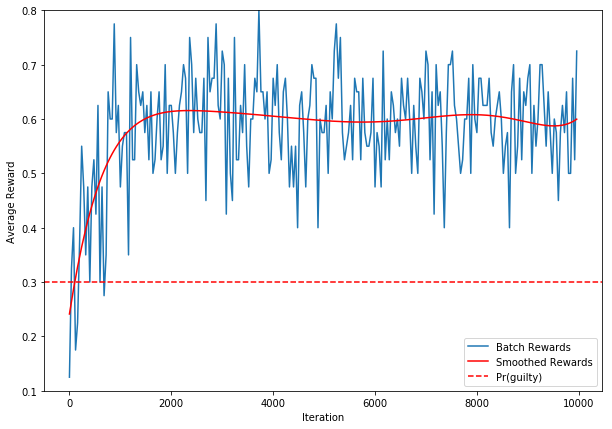

In [91]:
n_iters = int(1e4)
rewards, optimal_actions = persuasion_bandit(n_iters)
smooth_results = smooth_array(rewards, 20)
smooth_factor = 40 
results_smooth = smooth_array(rewards, smooth_factor)

# plot it
x = np.arange(len(results_smooth))
line = np.poly1d(np.polyfit(x=x, y=np.array(results_smooth), deg=7))
plt.figure(figsize=(10,7))
plt.plot(x*smooth_factor, results_smooth, label='Batch Rewards')
plt.plot(x*smooth_factor, line(x), 'r-', label='Smoothed Rewards')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.axhline(0.3, linestyle='--', color='red', label='Pr(guilty)')
plt.ylim((0.1, 0.8))
plt.legend()
plt.show()

## Varying Judge's Prior

Here we keep the ground truth of guilt constant but vary the judge's prior

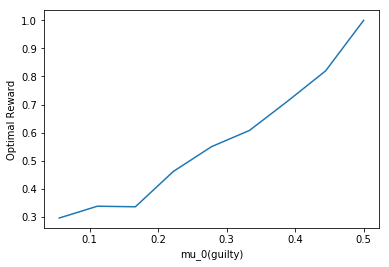

In [101]:
grid = np.linspace(0, 0.5, 10)
opt_means = []
for mu_0 in grid[1:]:
    #print("Running for p(guilty) = {}".format(mu_0))
    rewards, _ = persuasion_bandit(int(1e4), prior=mu_0)
    r_mean = np.mean(rewards[-500:])
    opt_means.append(r_mean)
    
plt.plot(grid[1:], opt_means)
plt.xlabel('mu_0(guilty)')
plt.ylabel('Optimal Reward')
plt.show()

## Varying Prior and Ground Truth

Here we look at a grid over judge's prior for guilt and the ground truth probability of a guilty defendant

In [104]:
n_iters = 6000
grid = np.linspace(0.05, 0.5, 10)
reward_arr = np.zeros((len(grid), len(grid)))
for prior_ix in range(len(grid)):
    print("mu_0(guilty) {}".format(grid[prior_ix]))
    for truth_ix in range(len(grid)):
        rewards, _ = persuasion_bandit(n_iters, grid[prior_ix], grid[truth_ix])
        reward_arr[prior_ix, truth_ix] = np.mean(rewards[-500:])

mu_0(guilty) 0.05
mu_0(guilty) 0.1
mu_0(guilty) 0.15000000000000002
mu_0(guilty) 0.2
mu_0(guilty) 0.25
mu_0(guilty) 0.3
mu_0(guilty) 0.35000000000000003
mu_0(guilty) 0.4
mu_0(guilty) 0.45
mu_0(guilty) 0.5


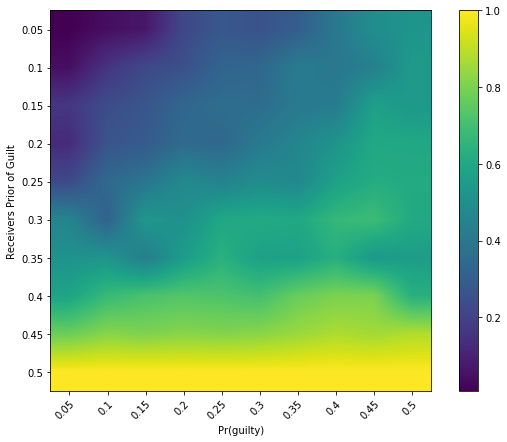

In [108]:
fig, ax = plt.subplots(figsize=(10,7))
im = ax.imshow(reward_arr, interpolation='bilinear')
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(grid)))
ax.set_yticks(np.arange(len(grid)))
# ... and label them with the respective list entries
ax.set_xticklabels(np.round(grid, 2))
ax.set_yticklabels(np.round(grid, 2))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.xlabel('Pr(guilty)')
plt.ylabel('Receivers Prior of Guilt')

plt.show()

## Multiple Receivers

Now I take a look at what would happen if there are multiple receivers who vote on the final outcome. The sender can send one signal to all three receivers, and each observe the same signal realization. Receivers observe the signal from the Sender and individually update their posteriors. The final verdict is made via majority vote. 

In [156]:
def persuasion_bandit_three_receivers(n_iters, prior=[0.3, 0.3, 0.3], p_guilty=0.3):
    """
    Function that runs persuasion bandits with multiple receivers with heterogeneous
    priors. Sender can only choose _one_ signal to send to all three. Decision to
    acquit or convict is made via majority vote. 
    
    INPUT:
        n_iters: (int) number of iterations to run
        prior: (np.array) length-3 array of p(guilt)
        p_guilty: (float) ground truth probability of guilt
        
    OUTPUT:
        rewards: (np.array) 
        optimal actions
    """
    # 7 actions to correspond to [GK13] optimum
    n_actions = 8
    
    # initialize true probability of guilt
    p_guilty = np.array([1-p_guilty, p_guilty])
    n_judges = len(prior)
    
    # set up prior so prior[0] = mu_0(innocent), etc. for each judge
    prior = np.array([[1-prior[0], prior[0]], 
                      [1-prior[1], prior[1]], 
                      [1-prior[2], prior[2]]])
    
    posterior = np.zeros((n_judges, 2))
    
    # initialize empty q function and action counts. axis 0 denotes choices
    # for p(g | innocent), axis 1 denotes choices for p(g | guilty).
    q_a = np.zeros((n_actions, n_actions))
    n_a = np.zeros((n_actions, n_actions))
    
    # keep track of rewards
    rewards = []
    for t in range(1, n_iters+1):
        
        # actions: bandit agent chooses p(g | i) and p(g | g)
        # these two probs completely characterize the distribution
        # ix_0: index (= numerator) of p(g | i), (along the 0th axis)
        # ix_1: index (= numerator) of p(g | g), (along the 1st axis)
        ix_0, ix_1 = ucb(q_a, n_a, t)
        
        # get signal realization probabilities
        p_gi, p_gg = np.divide([ix_0, ix_1], n_actions - 1)
        p_ii, p_ig = 1 - p_gi, 1 - p_gg
        
        # set up matrix so signal[0,0] gets you p(i | innocent), etc.
        pi = np.array([[p_ii, p_ig],[p_gi, p_gg]])
        
        # sample state of the world; 1 = guilty, 0 = innocent
        state = np.random.choice([0, 1], p=p_guilty)
        
        # signal realization
        if state == 1:
            signal = np.random.choice([0, 1], p=[p_ig, p_gg])
        elif state == 0:
            signal = np.random.choice([0, 1], p=[p_ii, p_gi])
        
        # form posterior for each state and judge
        for i in range(n_judges):   
            posterior[i, 0] = (pi[signal, 0] * prior[i, 0]) / (pi[signal, :] @ prior[i, :])
            posterior[i, 1] = (pi[signal, 1] * prior[i, 1]) / (pi[signal, :] @ prior[i, :])

            
        # get the judges votes
        votes = [get_reward(posterior[i]) for i in range(n_judges)]
        
        # get the verdict
        verdict = int(sum(votes) >= 2)
        
        # update Q and N functions:
        rewards.append(verdict)
        n_a[ix_0, ix_1] += 1
        q_a[ix_0, ix_1] += (verdict - q_a[ix_0, ix_1]) / n_a[ix_0, ix_1]
        
    return rewards, ucb(q_a, n_a, n_iters)

### Basic Case

Let's look at what happens when we have three judges with priors:

$$
\mu_0^{(1)} = 0.2
\mu_0^{(2)} = 0.3
\mu_0^{(3)} = 0.4
$$

i.e. we still have an average prior of 0.3.

In [160]:
n_iters = int(1e4)
rewards, optimal_actions = persuasion_bandit_three_receivers(n_iters, prior=[0.2, 0.3, 0.4])
smooth_results = smooth_array(rewards, 20)
smooth_factor = 40 
results_smooth = smooth_array(rewards, smooth_factor)

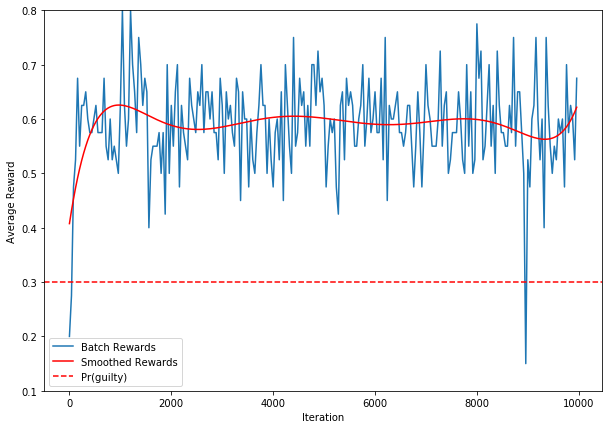

In [163]:
# plot it
x = np.arange(len(results_smooth))
line = np.poly1d(np.polyfit(x=x, y=np.array(results_smooth), deg=7))
plt.figure(figsize=(10,7))
plt.plot(x*smooth_factor, results_smooth, label='Batch Rewards')
plt.plot(x*smooth_factor, line(x), 'r-', label='Smoothed Rewards')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.axhline(0.3, linestyle='--', color='red', label='Pr(guilty)')
plt.ylim((0.1, 0.8))
plt.legend()
plt.show()

### Grid over Prior "Variance"

Here we fix one of the judge's priors at $0.3$ and vary the other two judges' priors to be some distance from $0.3$. 

In [176]:
window_grid = np.linspace(0, 0.3, 12)
n_iters = int(1e4)
means = []
se = []
for window in window_grid:
    priors = [0.3 - window, 0.3, 0.3 + window]
    rewards, optimal_actions = persuasion_bandit_three_receivers(n_iters, prior=priors)
    means.append(np.mean(rewards[-1500:]))
    se.append(np.std(rewards[-1500:]) / np.sqrt(len(rewards[-1500:])))

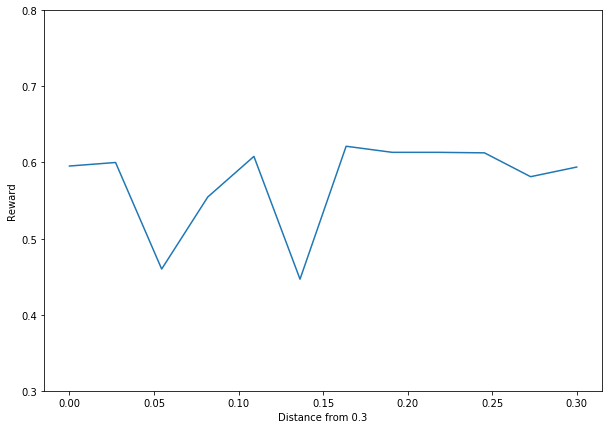

In [180]:
plt.figure(figsize=(10,7))
plt.plot(window_grid, means)
plt.ylim((0.3, 0.8))
plt.xlabel('Distance from 0.3')
plt.ylabel('Reward')
plt.show()

### Random Judges

Here we look at judges with priors sampled from $N(0.3, 0.1)$.

In [181]:
lower, upper = 0, 1
mu, sigma = 0.3, 0.1
a, b = (lower - mu) / sigma, (upper - mu) / sigma
dist = truncnorm(a, b, loc=mu, scale=sigma)

n_iters = int(5000)
reward_dict = {}
for i in range(10):
    draws = dist.rvs(3)
    rewards, _ = persuasion_bandit_three_receivers(n_iters, draws)
    reward_dict[str(draws)] = {'mean_reward': np.mean(rewards[-1000:]),
                               'mean_prior': np.mean(draws)}

In [182]:
reward_dict

{'[0.22502606 0.21751188 0.41010555]': {'mean_prior': 0.284214493584899,
  'mean_reward': 0.489},
 '[0.25900082 0.40884711 0.320183  ]': {'mean_prior': 0.32934364160096435,
  'mean_reward': 0.587},
 '[0.29081851 0.29341674 0.30404908]': {'mean_prior': 0.29609477663333966,
  'mean_reward': 0.515},
 '[0.29954141 0.28448581 0.25051286]': {'mean_prior': 0.2781800247022411,
  'mean_reward': 0.483},
 '[0.30620044 0.29015397 0.20358925]': {'mean_prior': 0.26664788561814473,
  'mean_reward': 0.507},
 '[0.30708461 0.29201288 0.38884044]': {'mean_prior': 0.32931264343264294,
  'mean_reward': 0.4},
 '[0.31075043 0.54530918 0.14364867]': {'mean_prior': 0.3332360921097637,
  'mean_reward': 0.621},
 '[0.32338894 0.51876346 0.34676525]': {'mean_prior': 0.39630588214770235,
  'mean_reward': 0.641},
 '[0.37164479 0.09294917 0.40242993]': {'mean_prior': 0.28900796518000854,
  'mean_reward': 0.69},
 '[0.41168378 0.45170674 0.37146573]': {'mean_prior': 0.41161874703486534,
  'mean_reward': 0.648}}